# Discount Optimization

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [87]:
data = pd.read_csv('final_data.csv')
data = data.drop(['Product_Desc','depoid','Product_Description','unique_ID','Depo_Prod_Unique_ID','Product_Nickname','Nama_Depo'],axis=1)
print(data.shape)
data.head()

(278623, 22)


,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,...,decUomConversion1,decUomConversion2,Final_Price_New,Total_Revenue_New,discount_pct,Year_Transaction,Month_Transaction,is_conversion_equal,Convert_to_box,Price_Difference
0,0074-15-000007073,90103211101100,0074-23-000078054,2023-01-02,1083.33,24,1981,Reguler,5405.41,NaN,...,1,1,858.11,20594.59,0.21,2023,1,True,1,225.23
1,0074-19-000012078,90103211101100,0074-23-000078100,2023-01-02,1083.33,24,1981,Reguler,5405.41,NaN,...,1,1,858.11,20594.59,0.21,2023,1,True,1,225.23
2,0074-19-000012232,90103211101100,0074-23-000078099,2023-01-02,1083.33,72,5945,Reguler,16216.22,NaN,...,1,1,858.11,61783.78,0.21,2023,1,True,3,225.23
3,8133-16-000001011,90103211101100,0074-23-000078112,2023-01-02,1083.33,24,1981,Reguler,5405.41,NaN,...,1,1,858.11,20594.59,0.21,2023,1,True,1,225.23
4,0049-18-000006660,90103211101100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,NaN,...,1,1,843.46,101215.32,0.25,2023,1,True,5,281.54


In [88]:
data = data.dropna()
data.shape

(210211, 22)

## feature engineering

In [90]:
drop_col = ['BOSnetszUomId', 'BOSnetdecUom', 'decUomConversion1', 'decUomConversion2','is_conversion_equal', 'Price_Difference']

data_purchased = data.drop(drop_col,axis=1)
data_purchased['Product_ID'] = data_purchased['Product_ID'].astype('str')
print(data_purchased.shape)
data_purchased.head()

(210211, 16)


,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Year_Transaction,Month_Transaction,Convert_to_box
5608,0074-19-000012078,90103211107100,0074-23-000078100,2023-01-02,1083.33,24,1981,Reguler,5405.41,727.19,858.11,20594.59,0.21,2023,1,1
5609,0049-18-000006660,90103211107100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5
5610,0049-18-000008369,90103211107100,0049-23-000035126,2023-01-03,1125.00,48,3963,Reguler,12612.61,742.10,862.24,41387.39,0.23,2023,1,2
5611,0049-13-000003123,90103211107100,0049-23-000035116,2023-01-03,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5
5612,0074-17-000009593,90103211107100,0074-23-000078212,2023-01-03,1083.33,48,3964,Reguler,10809.91,727.19,858.13,41190.09,0.21,2023,1,2


### if discount amt = 0, pct is 0

In [91]:
data_purchased[['Agg_Discount_Amount']][data_purchased['discount_pct']<0]

,Agg_Discount_Amount
92526,0.00
143958,0.00
206726,0.00
208606,0.00
211953,0.00
212663,0.00
237245,0.00
271415,0.00
271435,0.00


In [92]:
data_purchased['discount_pct'] = data_purchased.apply(lambda row: 0 if row['Agg_Discount_Amount'] == 0 else row['discount_pct'], axis=1)
data_purchased.head()

,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Year_Transaction,Month_Transaction,Convert_to_box
5608,0074-19-000012078,90103211107100,0074-23-000078100,2023-01-02,1083.33,24,1981,Reguler,5405.41,727.19,858.11,20594.59,0.21,2023,1,1
5609,0049-18-000006660,90103211107100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5
5610,0049-18-000008369,90103211107100,0049-23-000035126,2023-01-03,1125.00,48,3963,Reguler,12612.61,742.10,862.24,41387.39,0.23,2023,1,2
5611,0049-13-000003123,90103211107100,0049-23-000035116,2023-01-03,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5
5612,0074-17-000009593,90103211107100,0074-23-000078212,2023-01-03,1083.33,48,3964,Reguler,10809.91,727.19,858.13,41190.09,0.21,2023,1,2


### Create wholesaler-product column pair

In [93]:
data_purchased['Wholesaler_Product_ID'] = data_purchased['Wholesaler_ID'] + "-" + data_purchased['Product_ID']
data_purchased.head()

,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Year_Transaction,Month_Transaction,Convert_to_box,Wholesaler_Product_ID
5608,0074-19-000012078,90103211107100,0074-23-000078100,2023-01-02,1083.33,24,1981,Reguler,5405.41,727.19,858.11,20594.59,0.21,2023,1,1,0074-19-000012078-90103211107100
5609,0049-18-000006660,90103211107100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5,0049-18-000006660-90103211107100
5610,0049-18-000008369,90103211107100,0049-23-000035126,2023-01-03,1125.00,48,3963,Reguler,12612.61,742.10,862.24,41387.39,0.23,2023,1,2,0049-18-000008369-90103211107100
5611,0049-13-000003123,90103211107100,0049-23-000035116,2023-01-03,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5,0049-13-000003123-90103211107100
5612,0074-17-000009593,90103211107100,0074-23-000078212,2023-01-03,1083.33,48,3964,Reguler,10809.91,727.19,858.13,41190.09,0.21,2023,1,2,0074-17-000009593-90103211107100


### create profit, profit margin % col

In [94]:
# 1. Profit margin %
data_purchased['Profit_Margin_%'] = (
    (data_purchased['Final_Price_New'] - data_purchased['modal_per_pcs_inc_PPN'])
    / data_purchased['Final_Price_New'] )

# 2. Profit per unit
data_purchased['Profit_Per_Unit'] = data_purchased['Final_Price_New'] - data_purchased['modal_per_pcs_inc_PPN']

# 3. Total profit
data_purchased['Total_Profit'] = data_purchased['Profit_Per_Unit'] * data_purchased['Quantity_Sold']

data_purchased.head()

,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Year_Transaction,Month_Transaction,Convert_to_box,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit
5608,0074-19-000012078,90103211107100,0074-23-000078100,2023-01-02,1083.33,24,1981,Reguler,5405.41,727.19,858.11,20594.59,0.21,2023,1,1,0074-19-000012078-90103211107100,0.15,130.92,3142.10
5609,0049-18-000006660,90103211107100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5,0049-18-000006660-90103211107100,0.12,101.36,12162.79
5610,0049-18-000008369,90103211107100,0049-23-000035126,2023-01-03,1125.00,48,3963,Reguler,12612.61,742.10,862.24,41387.39,0.23,2023,1,2,0049-18-000008369-90103211107100,0.14,120.13,5766.38
5611,0049-13-000003123,90103211107100,0049-23-000035116,2023-01-03,1125.00,120,9662,Reguler,33784.68,742.10,843.46,101215.32,0.25,2023,1,5,0049-13-000003123-90103211107100,0.12,101.36,12162.79
5612,0074-17-000009593,90103211107100,0074-23-000078212,2023-01-03,1083.33,48,3964,Reguler,10809.91,727.19,858.13,41190.09,0.21,2023,1,2,0074-17-000009593-90103211107100,0.15,130.94,6285.10


There are some who have suffered losses because their cost price is higher than the selling price due to the high discounts

In [96]:
data_purchased[['Wholesaler_ID','Product_ID','modal_per_pcs_inc_PPN','Final_Price_New','discount_pct','Profit_Margin_%']][data_purchased['Profit_Margin_%']<0]

,Wholesaler_ID,Product_ID,modal_per_pcs_inc_PPN,Final_Price_New,discount_pct,Profit_Margin_%
7028,0074-20-000012678,90103211107100,727.19,710.00,0.15,-0.02
8803,0074-06-000000832,90103211116100,1305.21,1298.27,0.13,-0.01
10424,0074-04-000000313,90103211116100,1305.21,1280.67,0.15,-0.02
10775,0049-08-000000311,90103211116100,1305.21,1290.54,0.14,-0.01
10809,0049-17-000006608,90103211116100,1305.21,1250.00,0.17,-0.04
...,...,...,...,...,...,...
266545,0049-17-000005800,90103311143100,742.10,713.91,0.18,-0.04
266554,0049-17-000005800,90103311143100,742.10,713.93,0.18,-0.04
266782,0074-20-000012480,90103311143100,727.19,713.91,0.18,-0.02
268602,0049-17-000005800,90103311144100,742.10,612.76,0.30,-0.21


### Filter data so each wholesaler-product pair have more than 10 POs

In [97]:
data_purchased = data_purchased.groupby('Wholesaler_Product_ID').filter(lambda x : len(x)>=10)
print(data_purchased.shape)
print(len(list(data_purchased['Wholesaler_ID'].unique())))

(128660, 20)
1618


### Add price elasticity

In [98]:
# Calculate percentage changes in Quantity Sold and Final Price
data_purchased['Quantity_Change_%'] = data_purchased.groupby(['Wholesaler_ID', 'Product_ID'])['Quantity_Sold'].pct_change() * 100
data_purchased['Price_Change_%'] = data_purchased.groupby(['Wholesaler_ID', 'Product_ID'])['Final_Price_New'].pct_change() * 100

# Calculate Elasticity
data_purchased['Elasticity'] = data_purchased.apply(
    lambda row: row['Quantity_Change_%'] / row['Price_Change_%'] if row['Price_Change_%'] != 0 else np.nan,
    axis=1
)

# Fill NaN values (this will typically happen for the first row in each group)
data_purchased['Quantity_Change_%'] = data_purchased['Quantity_Change_%'].fillna(0)
data_purchased['Price_Change_%'] = data_purchased['Price_Change_%'].fillna(0)

# Cap elasticity to handle extreme outliers
data_purchased['Elasticity'] = data_purchased['Elasticity'].clip(-10, 10)
data_purchased['Elasticity'] = data_purchased['Elasticity'].fillna(0)

# minmax = MinMaxScaler()
# data_purchased['Elasticity'] = minmax.fit_transform(data_purchased[['Elasticity']])

#data_purchased = data_purchased.dropna()
print(data_purchased.shape)
data_purchased.head()

(128660, 23)


,Wholesaler_ID,Product_ID,PO_ID,Transaction_Date,Base_Price,Quantity_Sold,PPN,Discount_Type,Agg_Discount_Amount,modal_per_pcs_inc_PPN,...,Year_Transaction,Month_Transaction,Convert_to_box,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%,Elasticity
5609,0049-18-000006660,90103211107100,0049-23-000035048,2023-01-02,1125.00,120,9662,Reguler,33784.68,742.10,...,2023,1,5,0049-18-000006660-90103211107100,0.12,101.36,12162.79,0.00,0.00,0.00
5627,0049-17-000005662,90103211107100,0049-23-000035291,2023-01-05,1125.00,120,9662,Reguler,33784.68,742.10,...,2023,1,5,0049-17-000005662-90103211107100,0.12,101.36,12162.79,0.00,0.00,0.00
5628,0049-18-000006974,90103211107100,0049-23-000035294,2023-01-05,1125.00,240,19324,Reguler,67567.57,742.10,...,2023,1,10,0049-18-000006974-90103211107100,0.12,101.36,24327.38,0.00,0.00,0.00
5629,0049-08-000001311,90103211107100,0049-23-000035312,2023-01-05,1125.00,24,1932,Reguler,6755.86,742.10,...,2023,1,1,0049-08-000001311-90103211107100,0.12,101.40,2433.64,0.00,0.00,0.00
5631,0049-08-000000754,90103211107100,0049-23-000035315,2023-01-05,1125.00,120,9662,Reguler,33784.68,742.10,...,2023,1,5,0049-08-000000754-90103211107100,0.12,101.36,12162.79,0.00,0.00,0.00


### Customer segmentation

In [100]:
drop_col = ['PO_ID', 'Wholesaler_ID','Product_ID', 'Elasticity','Discount_Type','Transaction_Date','Convert_to_box', 'Year_Transaction']    
target = ['Quantity_Sold']
data_segment = data_purchased.drop(drop_col,axis=1)

In [101]:
encoder = TargetEncoder(cols=['Wholesaler_Product_ID'])  # or Wholesaler_Product_ID if you concatenate
encoder.fit(data_segment, data_segment[target])

data_segment = encoder.transform(data_segment)
data_segment.head()

,Base_Price,Quantity_Sold,PPN,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Month_Transaction,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%
5609,1125.00,120,9662,33784.68,742.10,843.46,101215.32,0.25,1,1462.14,0.12,101.36,12162.79,0.00,0.00
5627,1125.00,120,9662,33784.68,742.10,843.46,101215.32,0.25,1,1496.85,0.12,101.36,12162.79,0.00,0.00
5628,1125.00,240,19324,67567.57,742.10,843.47,202432.43,0.25,1,1481.69,0.12,101.36,24327.38,0.00,0.00
5629,1125.00,24,1932,6755.86,742.10,843.51,20244.14,0.25,1,1399.05,0.12,101.40,2433.64,0.00,0.00
5631,1125.00,120,9662,33784.68,742.10,843.46,101215.32,0.25,1,1057.51,0.12,101.36,12162.79,0.00,0.00


In [102]:
error = []
for n_clusters in range(1, 21):
    model = KMeans(init='k-means++',
                   n_clusters=n_clusters,
                   max_iter=500,
                   random_state=22)
    model.fit(data_segment)
    error.append(model.inertia_)

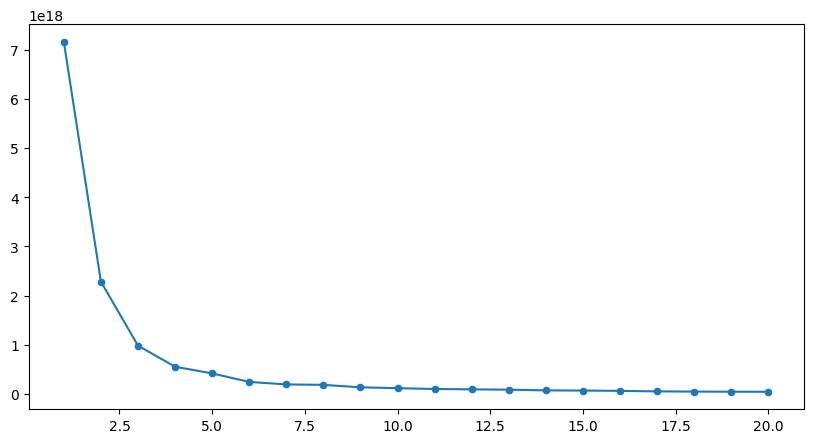

In [103]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 21), y=error)
sns.scatterplot(x=range(1, 21), y=error)
plt.show()

In [104]:
model = KMeans(init='k-means++',
               n_clusters=3,
               max_iter=500,
               random_state=42)
data_segment['Cluster'] = model.fit_predict(data_segment)

In [105]:
data_purchased['Cluster'] = model.fit_predict(data_segment)

In [106]:
data_segment['Cluster'].unique()

array([0, 2, 1], dtype=int32)

cluster 0 characteristics:

1. low sales, inconsistent revenue, indicating **small to medium-scale buyers**
2. some transactions are poorly priced leads to negative profit margin
3. low discounts, but there are huge discounts = 51% for such small sales

In [107]:
pd.options.display.float_format = '{:.2f}'.format

In [108]:
data_segment[['modal_per_pcs_inc_PPN','Final_Price_New','Quantity_Sold','Agg_Discount_Amount','discount_pct','Profit_Margin_%','Total_Revenue_New','Total_Profit']][data_segment['Cluster']==0].describe()

,modal_per_pcs_inc_PPN,Final_Price_New,Quantity_Sold,Agg_Discount_Amount,discount_pct,Profit_Margin_%,Total_Revenue_New,Total_Profit
count,124354.00,124354.00,124354.00,124354.00,124354.00,124354.00,124354.00,124354.00
mean,849.82,940.51,735.81,44563.66,0.03,0.10,628130.81,38608.62
std,232.89,251.54,1952.44,149240.40,0.03,0.03,1628332.44,96556.57
min,727.19,709.04,2.00,0.00,0.00,-0.84,1642.00,-906807.37
25%,727.19,798.65,24.00,0.00,0.00,0.08,35351.35,3447.50
50%,727.19,818.80,72.00,1581.08,0.02,0.10,68718.02,6895.01
75%,742.10,870.83,360.00,13621.62,0.05,0.11,302797.30,23759.81
max,1305.21,1600.02,15600.00,2332207.21,0.51,0.37,11678354.74,2266968.34


cluster 1 characteristics:

1. high sales, massive and consistent revenue and profit, around 79M and 4M respectively, indicating **large wholesalers**
2. moderate discount, some doesnt get discount
3. walaupun dapet diskon 0, jumlah barang yang dibeli tetep tinggi karena min sales nya 36rb

In [109]:
data_segment[['modal_per_pcs_inc_PPN','Final_Price_New','Quantity_Sold','Agg_Discount_Amount','discount_pct','Profit_Margin_%','Total_Revenue_New','Total_Profit']][data_segment['Cluster']==1].describe()

,modal_per_pcs_inc_PPN,Final_Price_New,Quantity_Sold,Agg_Discount_Amount,discount_pct,Profit_Margin_%,Total_Revenue_New,Total_Profit
count,721.00,721.00,721.00,721.00,721.00,721.00,721.00,721.00
mean,760.73,807.50,99592.38,4362102.68,0.05,0.06,79442193.65,4693908.55
std,105.49,112.54,26449.72,4059290.87,0.04,0.03,20037009.22,2667019.65
min,727.19,750.73,36000.00,0.00,0.00,0.01,51081081.08,413061.62
25%,742.10,768.84,80400.00,467649.55,0.00,0.04,63471270.24,2776131.50
50%,742.10,776.69,96000.00,3988490.99,0.05,0.05,75121612.56,3827176.05
75%,742.10,814.90,122688.00,6778379.28,0.09,0.09,98792045.60,6082928.92
max,1305.21,1445.95,247200.00,29090541.44,0.14,0.14,186179471.33,14976761.20


In [110]:
cluster_1 = data_segment[data_segment['Cluster']==1]
cluster_1[cluster_1['Quantity_Sold']==cluster_1['Quantity_Sold'].min()]

,Base_Price,Quantity_Sold,PPN,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Month_Transaction,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%,Cluster
19960,1500.00,36000,5030270,2918918.92,1305.21,1418.92,51081081.08,0.05,4,16626.24,0.08,113.71,4093582.28,100.00,-0.00,1


cluster 2 characteristics:

1. Total revenue is around 22M and consistent, indicating **mid-volume buyers**
2. Has the highest discount % average  among all clusters, under 75% of data reach almost 11% discount
3. This cluster indicates that discount is needed in order to drive more sales

In [111]:
data_segment[['modal_per_pcs_inc_PPN','Final_Price_New','Quantity_Sold','Agg_Discount_Amount','discount_pct','Profit_Margin_%','Total_Revenue_New','Total_Profit']][data_segment['Cluster']==2].describe()

,modal_per_pcs_inc_PPN,Final_Price_New,Quantity_Sold,Agg_Discount_Amount,discount_pct,Profit_Margin_%,Total_Revenue_New,Total_Profit
count,3585.00,3585.00,3585.00,3585.00,3585.00,3585.00,3585.00,3585.00
mean,876.90,923.96,26217.64,1567980.25,0.06,0.05,22680935.46,1191182.75
std,246.44,253.75,12815.60,1349908.39,0.04,0.03,9492672.85,845408.68
min,727.19,731.98,8352.00,0.00,0.00,-0.07,11647167.57,-969492.28
25%,727.19,768.84,16800.00,154867.57,0.00,0.03,14912433.42,641748.25
50%,742.10,776.69,24000.00,1456755.86,0.07,0.04,18738739.63,968440.93
75%,742.10,847.30,36000.00,2270270.27,0.11,0.06,28892839.83,1489804.87
max,1305.21,1500.00,67104.00,7896810.81,0.18,0.15,51209774.94,5605497.24


In [112]:
cluster_2 = data_segment[data_segment['Cluster']==2]
cluster_2[cluster_2['Quantity_Sold']==cluster_2['Quantity_Sold'].max()]

,Base_Price,Quantity_Sold,PPN,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Month_Transaction,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%,Cluster
270777,870.83,67104,4922345,7896810.81,742.10,753.15,50539593.13,0.14,3,34016.51,0.01,11.05,741421.15,86.40,0.00,2


In [113]:
cluster_2[cluster_2['discount_pct']==cluster_2['discount_pct'].max()]

,Base_Price,Quantity_Sold,PPN,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Month_Transaction,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%,Cluster
90807,1500.00,11976,1417359,3298693.69,1305.21,1224.56,14665305.30,0.18,4,2481.17,-0.07,-80.65,-965869.30,399.00,1.39,2


## Helper function

### ML modeling to predict quantity

In [114]:
def modeling(X, y):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    
    # encode
    encoder = TargetEncoder(cols=['Wholesaler_Product_ID'])  # or Wholesaler_Product_ID if you concatenate
    encoder.fit(X_train, y_train)

    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    r2_adjusted_train = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    r2_adjusted_test = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

    # print("R-squared (R²) Score:", r2)
    # print("R² Adjusted Train Score:", r2_adjusted_train)
    # print("R² Adjusted Test Score:", r2_adjusted_test)
    print(y_test.head())

    return {'encoder':encoder,
            'model':model,
            'r2':r2,
            'r2_adj_train': r2_adjusted_train,
            'r2_adj_test': r2_adjusted_test}

### simulate discount

In [115]:
def simulate_disc(pred_target, data, drop_col, target, disc, encoder, model):
  new_data = data.drop(drop_col+ target, axis=1)
  new_data['discount_pct'] = disc

  # calculate discount amount & final price manually because of new discount %
  new_data['Agg_Discount_Amount'] = new_data['Base_Price'] * new_data['discount_pct']
  new_data['Final_Price_New'] = new_data['Base_Price'] - new_data['Agg_Discount_Amount']
  new_data['Profit_Margin_%'] = (new_data['Final_Price_New'] - new_data['modal_per_pcs_inc_PPN']) / new_data['Final_Price_New']
  # Apply encodings
  new_data_encoded = encoder.transform(new_data)

  if pred_target == "revenue":
    # Predict
    predicted_revenue = model.predict(new_data_encoded)
    new_data['Predicted_Revenue'] = predicted_revenue
    new_data['Predicted_Quantity'] = new_data['Predicted_Revenue'] / new_data['Final_Price_New']

  if pred_target == "quantity":
      predicted_quantity = model.predict(new_data_encoded)
      new_data['Predicted_Quantity'] = predicted_quantity
      new_data['Predicted_Revenue'] = new_data['Predicted_Quantity'] * new_data['Final_Price_New']
      new_data['Predicted_Profit'] = new_data['Predicted_Quantity'] * (
          new_data['Final_Price_New'] - new_data['modal_per_pcs_inc_PPN']
      )

  return new_data

## Predict qty sold

In [116]:
drop_col = ['PO_ID', 'Wholesaler_ID','Product_ID', 'Elasticity','Discount_Type','Transaction_Date','Convert_to_box', 'Year_Transaction']   
target = ['Quantity_Sold']
X = data_purchased.drop(drop_col+target,axis=1)
#val = data_purchased[-50:]
y = data_purchased[target]

In [117]:
result = modeling(X, y)
result

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


        Quantity_Sold
262439             24
83473              48
93111              24
38755              24
203178           7248


{'encoder': TargetEncoder(cols=['Wholesaler_Product_ID']),
 'model': RandomForestRegressor(random_state=42),
 'r2': 0.9998658854403886,
 'r2_adj_train': 0.9998214626358376,
 'r2_adj_test': 0.9998658072121107}

## Simulate hardcoded new discount

In [118]:
data_purchased[['Quantity_Sold','Total_Revenue_New','Final_Price_New','discount_pct','Profit_Margin_%','Total_Profit','Cluster']][(data_purchased['Wholesaler_ID']=='0049-20-000009207') & (data_purchased['Product_ID']=='90103211107100')].head(1)

,Quantity_Sold,Total_Revenue_New,Final_Price_New,discount_pct,Profit_Margin_%,Total_Profit,Cluster
5664,2400,2687837.84,1119.93,0.00,0.34,906787.34,0


customer is relatively reactive to price change, initial discount was 0.4% then we give them 2% discount

In [119]:
data = data_purchased[(data_purchased['Wholesaler_ID']=='0049-20-000009207') & (data_purchased['Product_ID']=='90103211107100')].head(1)
simulate_disc("quantity",data,drop_col,target,0.02, result.get('encoder'), result.get('model'))

,Base_Price,PPN,Agg_Discount_Amount,modal_per_pcs_inc_PPN,Final_Price_New,Total_Revenue_New,discount_pct,Month_Transaction,Wholesaler_Product_ID,Profit_Margin_%,Profit_Per_Unit,Total_Profit,Quantity_Change_%,Price_Change_%,Cluster,Predicted_Quantity,Predicted_Revenue,Predicted_Profit
5664,1125.00,266229,22.50,742.10,1102.50,2687837.84,0.02,1,0049-20-000009207-90103211107100,0.33,377.83,906787.34,0.00,0.00,0,2530.80,2790207.00,912089.25


## Find optimized discount

using minimize() function from scipy to find the discount that maximizes profit

Since we want to maximize profit, we convert Maximize profit to Minimize (–profit)

It tries to find the x (the discount) that minimizes f(x) using iterative methods like SLSQP (Sequential Least Squares Programming)

1. Input to minimize():
A discount value x[0]

2. Objective function:
f(x) to minimize -profit by calculating predicted quantity using regression coefficients

3. Computes final price from discount: Calculates profit = (final price – cost) × quantity then returns –profit (because we want to maximize it)

4. Constraints:

- Discount must be between 0.5% and 45%

- Final price must be ≥ cost

Why minimize and not linear programming?

D = discount

- Final price = Base_Price * (1 - D) → linear in D

- But profit = (Final price - cost) * Predicted quantity → not constant because profit is dependant to quantity

This is a product of two linear terms in D, which results in a nonlinear (specifically, quadratic) function.
That means the objective function is not linear, so linear programming can't be used.



In [120]:
results = []

# Group the data to optimize each Wholesaler_Product_ID separately
grouped = data_purchased.groupby('Wholesaler_Product_ID')

for key, group in grouped:
    # if group['discount_pct'].nunique() < 2:
    #     continue  # Skip if not enough variation in discount

    # Separate features and target
    X = group.drop(columns=drop_col+target)
    y = group['Quantity_Sold']

    # Encode categorical (if needed)
    if 'Wholesaler_Product_ID' in X.columns:
        encoder = TargetEncoder(cols=['Wholesaler_Product_ID'])
        X = encoder.fit_transform(X, y)

    # Fit regression
    # Using linear regression to stimate how Quantity_Sold responds to discount_pct + other variables
    reg = LinearRegression()
    reg.fit(X, y)

    # To evaluate what happens if we change the discount, we need to recalculate the predicted quantity
    # use intercept & coef as a way to predict a new value given changes in features (like a different discount)
    intercept = reg.intercept_
    coef = dict(zip(X.columns, reg.coef_))

    # Use latest price and cost from group
    base_price = group['Base_Price'].iloc[-1]
    cost = group['modal_per_pcs_inc_PPN'].iloc[-1]

    # Fixed values for features (other than discount_pct)
    latest_features = X.iloc[-1].to_dict()

    # define objective function
    # Returns negative profit so that minimize() can maximize it
    def objective(x):
        D = x[0]
        features = latest_features.copy()
        features['discount_pct'] = D
        predicted_quantity = intercept + sum(coef[k] * features[k] for k in coef)
        final_price = base_price * (1 - D)
        profit = (final_price - cost) * predicted_quantity
        return -profit

    # Constraints: 0% ≤ D ≤ 45% and final price ≥ cost
    max_discount = max(0, 1 - cost / base_price)
    constraints = [
        # {'type': 'ineq', 'fun': lambda x: x[0] - 0},                          # D ≥ 0.005
        # {'type': 'ineq', 'fun': lambda x: 0.5 - x[0]},                          # D ≤ 0.50
        {"type": "ineq", "fun": lambda x: min(0.45, max_discount) - x[0]},       # Final price ≥ cost
        {'type': 'ineq', 'fun': lambda x: base_price * (1 - x[0]) - cost} 
    ]

    x0 = np.array(group['discount_pct'])
    bounds = [(0.00, 0.45)]
    opt_result = minimize(objective, x0=x0, constraints=constraints, bounds=bounds,method='SLSQP')

    if opt_result.success:
        # Extract wholesaler and product IDs from the group
        wholesaler_id = group['Wholesaler_ID'].iloc[0]
        product_id = group['Product_ID'].iloc[0]
        opt_disc = round(opt_result.x[0], 3)
        base_price = group['Base_Price'].iloc[0]
        cost = group['modal_per_pcs_inc_PPN'].iloc[0]
        past_price = group['Final_Price_New'].iloc[0]
        past_discount = group['discount_pct'].iloc[0]
        past_qty = group['Quantity_Sold'].iloc[0]
        past_profit = group['Total_Profit'].iloc[0]
        cluster = group['Cluster'].iloc[0]

        features = latest_features.copy()
        features['discount_pct'] = opt_disc
        predicted_quantity = intercept + sum(coef[k] * features[k] for k in coef)

        optimized_discount_amt = base_price * opt_disc
        new_final_price = base_price - optimized_discount_amt
        profit_margin_pct = (new_final_price - cost) / new_final_price
        profit_per_unit = new_final_price - cost
        total_profit = profit_per_unit * predicted_quantity

        results.append({
            'Wholesaler_ID': wholesaler_id,
            'Product_ID': product_id,
            'past_price': past_price,
            'past_discount': past_discount,
            'past_qty': past_qty,
            'past_profit':past_profit,
            'optimized_discount': opt_disc,
            'optimized_discount_amt': optimized_discount_amt,
            'opt_predicted_quantity': predicted_quantity,
            'opt_predicted_profit':total_profit,
            'new_final_price': new_final_price,
            'cluster':cluster
        })

# Convert results to DataFrame
optimized_df = pd.DataFrame(results)

In [121]:
# discount structure
optimized_df

,Wholesaler_ID,Product_ID,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster
0,0049-08-000000003,90103211107100,843.47,0.25,96,9730.95,0.00,0.00,72.00,27568.48,1125.00,0
1,0049-08-000000003,90103211116100,1351.35,0.10,72,3322.30,0.10,148.50,96.00,4444.00,1351.50,0
2,0049-08-000000003,90103211121100,1351.35,0.10,48,2214.87,0.00,0.00,24.00,4675.00,1500.00,0
3,0049-08-000000003,90103211122100,1351.35,0.10,48,2214.87,0.08,120.00,72.00,5385.00,1380.00,0
4,0049-08-000000003,90103211144100,818.69,0.06,96,7352.57,0.00,0.00,72.00,9568.49,875.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6857,8133-18-000001439,90103211116100,1364.86,0.09,840,50111.51,0.09,135.00,1560.00,93275.05,1365.00,0
6858,8133-18-000001439,90103211122100,1364.86,0.09,360,21476.36,0.09,135.00,720.00,43050.02,1365.00,0
6859,8133-18-000001439,90103211146100,795.80,0.05,1200,82330.12,0.04,37.50,2400.00,164750.33,795.83,0
6860,8133-18-000001439,90103232126100,795.80,0.05,1200,82330.12,0.04,37.50,2400.00,164750.33,795.83,0


In [122]:
optimized_df['optimized_discount'].unique()

array([0.   , 0.099, 0.08 , 0.072, 0.09 , 0.086, 0.064, 0.054, 0.043,
       0.006, 0.055, 0.109, 0.01 , 0.022, 0.107, 0.023, 0.004, 0.001,
       0.063, 0.068, 0.092, 0.108, 0.009, 0.002, 0.018, 0.046, 0.034,
       0.021, 0.045, 0.012, 0.005, 0.008, 0.139, 0.003, 0.135, 0.007,
       0.073, 0.041, 0.05 , 0.091, 0.057, 0.081, 0.032, 0.027, 0.062,
       0.029, 0.065, 0.011, 0.083, 0.061, 0.036, 0.052, 0.106, 0.017,
       0.025, 0.016, 0.077, 0.117, 0.014, 0.026, 0.031, 0.082])

## Compare the result of optimized discount to random forest result

applying the optimized discount to random forest model to predict quantity & profit

In [123]:
comparison = optimized_df.copy()

there's a significant difference between opt_predicted_quantity and rf_predicted_quantity,

because opt_predicted_quantity uses linear regression, while rf_predicted_quantity use random forest, which learns the pattern better

jika minimal diskon yg diberikan adalah 0, model bisa memberikan angka 0 adalah diskon yg optimal

jika minimalnya 0.05, maka 0.05 adalah batas bawah diskon yg diberikan, beresiko banyak yg profitnya turun saat diberikan diskon

In [124]:
for i in range(comparison.shape[0]):
    row = comparison.iloc[i]
    wholesaler_id = row['Wholesaler_ID']
    product_id = row['Product_ID']
    optim_disc = row['optimized_discount']

    subset = data_purchased[
        (data_purchased['Wholesaler_ID'] == wholesaler_id) &
        (data_purchased['Product_ID'] == product_id)
    ]

    res = simulate_disc("quantity", subset, drop_col, target, optim_disc, result.get('encoder'), result.get('model'))

    # Use first predicted value (assumes one row or that the first is representative)
    # comparison.at[i, 'discount_act'] = subset['discount_pct'].iloc[0]
    # comparison.at[i, 'quantity_sold_act'] = subset['Quantity_Sold'].iloc[0]
    # comparison.at[i, 'profit_act'] = subset['Total_Profit'].iloc[0]
    comparison.at[i, 'rf_predicted_quantity'] = res['Predicted_Quantity'].iloc[0]
    comparison.at[i, 'rf_predicted_profit'] = res['Predicted_Profit'].iloc[0]

comparison

,Wholesaler_ID,Product_ID,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit
0,0049-08-000000003,90103211107100,843.47,0.25,96,9730.95,0.00,0.00,72.00,27568.48,1125.00,0,86.16,32990.29
1,0049-08-000000003,90103211116100,1351.35,0.10,72,3322.30,0.10,148.50,96.00,4444.00,1351.50,0,72.00,3333.00
2,0049-08-000000003,90103211121100,1351.35,0.10,48,2214.87,0.00,0.00,24.00,4675.00,1500.00,0,48.00,9350.00
3,0049-08-000000003,90103211122100,1351.35,0.10,48,2214.87,0.08,120.00,72.00,5385.00,1380.00,0,48.00,3590.00
4,0049-08-000000003,90103211144100,818.69,0.06,96,7352.57,0.00,0.00,72.00,9568.49,875.00,0,96.00,12757.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,8133-18-000001439,90103211116100,1364.86,0.09,840,50111.51,0.09,135.00,1560.00,93275.05,1365.00,0,841.92,50339.83
6858,8133-18-000001439,90103211122100,1364.86,0.09,360,21476.36,0.09,135.00,720.00,43050.02,1365.00,0,360.00,21525.01
6859,8133-18-000001439,90103211146100,795.80,0.05,1200,82330.12,0.04,37.50,2400.00,164750.33,795.83,0,1176.24,80744.14
6860,8133-18-000001439,90103232126100,795.80,0.05,1200,82330.12,0.04,37.50,2400.00,164750.33,795.83,0,1176.96,80793.56


### comparison per cluster

In [125]:
cluster_0_comparison = comparison[comparison['cluster']==0]
cluster_1_comparison = comparison[comparison['cluster']==1]
cluster_2_comparison = comparison[comparison['cluster']==2]

**CLUSTER 0 : small to medium scale buyers**

📉 Discounts decreased slightly (mean: 4% → 2%).

📦 Quantity dropped slightly, but

💰 Profit increased significantly (~43% increase).

🧠 For this cluster, the model reduces discounts without hurting sales volume significantly and boosts profit — optimal margin management.

In [126]:
cluster_0_comparison.describe()

,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit
count,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00,6838.00
mean,957.91,0.04,428.59,27089.37,0.02,18.60,520.12,46649.37,977.00,0.00,415.98,39108.74
std,253.57,0.04,1254.70,74248.79,0.03,34.05,2107.30,202591.13,262.35,0.00,1199.31,127581.23
min,731.98,0.00,24.00,115.07,0.00,0.00,24.00,1929.49,732.06,0.00,24.00,132.02
25%,808.07,0.00,24.00,4026.35,0.00,0.00,24.00,4243.00,832.50,0.00,24.00,4675.00
50%,833.33,0.02,72.00,7075.00,0.00,0.00,48.00,6895.01,870.83,0.00,72.00,8486.00
75%,870.83,0.07,240.00,19411.97,0.02,19.17,240.00,20875.03,875.00,0.00,240.00,20938.29
max,1600.02,0.27,14400.00,1497676.42,0.14,175.50,48000.00,5766411.21,1600.02,0.00,14328.00,1991830.46


**CLUSTER 1 : Large wholesalers**

⚖️ Discounts are already optimized (14%), and further discounting doesn’t help (past discount & optimized discount are same)

🔁 Slightly drop in quantity (~3k sales) and profit (~Rp 2.000 lower than past profit)

? same discount but drops happened, because that is only a prediction, and the discount decimal might be different

📊 High std devs suggest very diverse customers or pricing structures.

🧠 This cluster seems like already in the maximum efficiency.

 Trying further optimization doesn't hurt, and might need further discussion regarding the amount of discount should be given to wholesalers in this cluster

In [127]:
cluster_1_comparison.describe()

,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,783.05,0.09,109924.00,3525404.22,0.09,79.10,41200.00,1772765.99,783.68,1.00,106617.68,3525072.33
std,48.76,0.07,37471.07,2731344.38,0.07,59.60,9191.30,2116910.88,49.12,0.00,34341.72,2779197.99
min,753.15,0.00,64800.00,1206530.74,0.00,0.00,30000.00,401994.20,753.27,1.00,65655.12,1194201.50
25%,753.15,0.04,76512.00,1458379.34,0.04,32.66,34200.00,549392.05,753.27,1.00,76137.42,1415908.61
50%,753.15,0.14,117600.00,2697446.51,0.14,117.56,41400.00,732998.81,753.27,1.00,113566.44,2571708.19
75%,802.38,0.14,139464.00,4661625.18,0.14,117.56,47700.00,2028003.11,805.19,1.00,130858.32,4835293.11
max,866.91,0.14,149976.00,8189293.22,0.14,117.56,52800.00,5820743.08,866.48,1.00,146634.72,8192352.60


**CLUSTER 2 : mid-volume buyers**

📦 Small quantity drop (~300 units), but

💰 Massive profit gain: ~30% increase.

📈 Despite lowering discounts, RF predicts better profit and almost the same sales.

🧠 Cluster 2 responds well to careful discount control, and profit can be significantly boosted by small pricing tweaks.

In [128]:
cluster_2_comparison.describe()

,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,959.07,0.05,22809.33,1515454.53,0.03,29.13,18072.00,1426278.19,980.34,2.00,22465.65,1979352.11
std,281.50,0.05,8397.18,946927.75,0.04,46.17,14618.65,1084981.51,268.07,0.00,8241.11,1113296.80
min,731.98,0.00,9600.00,115073.87,0.00,0.00,1200.00,137876.82,776.67,2.00,9541.68,751111.97
25%,778.06,0.00,17586.00,821642.82,0.00,0.00,6300.00,532259.03,805.21,2.00,16705.80,981704.75
50%,808.84,0.03,24000.00,1103555.27,0.01,5.57,14460.00,1360479.04,830.91,2.00,22905.36,1926965.66
75%,1215.20,0.11,25260.00,2223501.22,0.04,48.38,24054.00,2076181.84,1221.21,2.00,25333.44,2425417.07
max,1439.19,0.12,42000.00,3683765.17,0.11,162.00,48000.00,3666729.85,1438.50,2.00,41890.80,4913487.00


### another simulation

In [129]:
comparison[(comparison['Wholesaler_ID']=='0049-20-000009207') & (comparison['Product_ID']=='90103211107100')]

,Wholesaler_ID,Product_ID,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit
1464,0049-20-000009207,90103211107100,1119.93,0.00,2400,906787.34,0.01,5.62,480.00,181089.90,1119.38,0,2530.80,954796.50


In [130]:
comparison['qty_difference'] = comparison['past_qty'] - comparison['rf_predicted_quantity']
comparison['profit_difference'] = comparison['past_profit'] - comparison['rf_predicted_profit']

In [131]:
# predicted higher than actual = optimized discount might work
comparison[comparison['profit_difference']<0]

,Wholesaler_ID,Product_ID,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit,qty_difference,profit_difference
0,0049-08-000000003,90103211107100,843.47,0.25,96,9730.95,0.00,0.00,72.00,27568.48,1125.00,0,86.16,32990.29,9.84,-23259.33
1,0049-08-000000003,90103211116100,1351.35,0.10,72,3322.30,0.10,148.50,96.00,4444.00,1351.50,0,72.00,3333.00,0.00,-10.70
2,0049-08-000000003,90103211121100,1351.35,0.10,48,2214.87,0.00,0.00,24.00,4675.00,1500.00,0,48.00,9350.00,0.00,-7135.14
3,0049-08-000000003,90103211122100,1351.35,0.10,48,2214.87,0.08,120.00,72.00,5385.00,1380.00,0,48.00,3590.00,0.00,-1375.14
4,0049-08-000000003,90103211144100,818.69,0.06,96,7352.57,0.00,0.00,72.00,9568.49,875.00,0,96.00,12757.98,0.00,-5405.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,8133-18-000001411,90103232126100,814.56,0.02,120,10485.26,0.00,0.00,48.00,5095.01,833.33,0,120.00,12737.52,0.00,-2252.25
6855,8133-18-000001411,90103232128100,814.56,0.02,120,10485.26,0.00,0.00,48.00,5095.01,833.33,0,120.00,12737.52,0.00,-2252.25
6857,8133-18-000001439,90103211116100,1364.86,0.09,840,50111.51,0.09,135.00,1560.00,93275.05,1365.00,0,841.92,50339.83,-1.92,-228.31
6858,8133-18-000001439,90103211122100,1364.86,0.09,360,21476.36,0.09,135.00,720.00,43050.02,1365.00,0,360.00,21525.01,0.00,-48.65


In [132]:
# actual higher than predicted, optimized discount might need to be further discussed
comparison[comparison['profit_difference']>0]

,Wholesaler_ID,Product_ID,past_price,past_discount,past_qty,past_profit,optimized_discount,optimized_discount_amt,opt_predicted_quantity,opt_predicted_profit,new_final_price,cluster,rf_predicted_quantity,rf_predicted_profit,qty_difference,profit_difference
15,0049-08-000000007,90103211146100,799.92,0.09,1200,69384.66,0.09,75.25,600.00,34587.37,799.75,0,1179.12,67971.11,20.88,1413.55
19,0049-08-000000007,90103311133100,784.53,0.10,6000,254580.96,0.10,86.21,2400.00,102039.50,784.62,0,5881.68,250068.20,118.32,4512.75
21,0049-08-000000007,90103311141100,784.53,0.10,1200,50916.19,0.10,86.21,600.00,25509.87,784.62,0,1183.92,50336.08,16.08,580.11
24,0049-08-000000016,90103211146100,818.69,0.06,480,36762.87,0.06,56.00,1176.00,90429.26,819.00,0,476.16,36614.62,3.84,148.25
27,0049-08-000000016,90103311141100,784.53,0.10,1200,50916.19,0.10,86.21,1200.00,51019.75,784.62,0,1183.92,50336.08,16.08,580.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,8133-17-000001369,90103232128100,795.80,0.05,720,49398.07,0.04,37.50,480.00,32950.07,795.83,0,711.60,48848.47,8.40,549.60
6848,8133-17-000001369,90103311133100,784.53,0.10,6000,344083.03,0.10,86.21,2400.00,137840.33,784.62,0,5872.80,337295.29,127.20,6787.74
6850,8133-17-000001369,90103311141100,784.53,0.10,480,27526.64,0.10,86.21,240.00,13784.03,784.62,0,473.04,27168.33,6.96,358.31
6859,8133-18-000001439,90103211146100,795.80,0.05,1200,82330.12,0.04,37.50,2400.00,164750.33,795.83,0,1176.24,80744.14,23.76,1585.98
